In [34]:
import os
os.system('export PYSYN_CDBS=/home/kiran/kurucz_models/grp/hst/cdbs/')
# or
# export PYSYN_CDBS=/media/kiran/New Volume/SEM_6/Internship/kurucz_models/grp/hst/cdbs/
# Run the above line in the command prompt before using this code ... open terminal in folder kurucz_models and type this

import numpy as np
import matplotlib.pyplot as plt
import time
from astropy.io import fits
#import spectres
from scipy.stats import chisquare
from scipy import stats
from astropy import units as u
from astropy import constants as const
import pysynphot as S
import spectres
import csv
import scipy.integrate as integrate
from PyAstronomy import pyasl
from csv import reader


In [59]:
def reduced_chi_square(x,y,s,m): # ddof = v
    v = x.size - m
    chi2 = (np.sum((x-y)**2/s**2))/v
    p = 1 - stats.chi2.cdf(chi2, v)
    return chi2,p

def get_photometric_flux(m_wave,interpolated_flux,F):
    for X in list(F.keys()):
        w = []
        Sx = []
        with open("Bessel_{}-1.txt".format(X),'r') as f:
            for line in f:
                y = line.split()
                if(y[0] == '#cumulative'):
                    cumulative_sum = float(y[-1])
                elif(y[0] == '</div>'):
                    break
                else:
                    y = [float(i) for i in line.split()]
                    w.append(y[0]*(10)) # for converting nm to A
                    Sx.append(y[1])
        w = np.array(w[::-1])
        Sx = np.array(Sx[::-1])
        wave = np.array(list(set().union(w,m_wave)))
        wave = np.sort(wave)
        idx = np.where(np.logical_and(wave>=1000, wave<=100000))
        wave = wave[idx]
        interpolated_Sx = np.interp(wave, w, Sx)
        interpolated_m_flux = np.interp(wave, m_wave, interpolated_flux)
        F[X] = integrate.simps(interpolated_Sx*interpolated_m_flux, wave)/integrate.simps(interpolated_Sx, wave)
    return F

def get_photometric_flux_band(m_wave,interpolated_flux,band):
    w = []
    Sx = []
    with open("Bessel_{}-1.txt".format(band),'r') as f:
        for line in f:
            y = line.split()
            if(y[0] == '#cumulative'):
                cumulative_sum = float(y[-1])
            elif(y[0] == '</div>'):
                break
            else:
                y = [float(i) for i in line.split()]
                w.append(y[0]*(10)) # for converting nm to A
                Sx.append(y[1])
    w = np.array(w[::-1])
    Sx = np.array(Sx[::-1])
    wave = np.array(list(set().union(w,m_wave)))
    wave = np.sort(wave)
    idx = np.where(np.logical_and(wave>=1000, wave<=100000))
    wave = wave[idx]
    interpolated_Sx = np.interp(wave, w, Sx)
    interpolated_m_flux = np.interp(wave, m_wave, interpolated_flux)
    return integrate.simps(interpolated_Sx*interpolated_m_flux, wave)/integrate.simps(interpolated_Sx, wave)

def get_dist_modulus(m,D):
    return m+5-5*np.log10(D.value)

class LessPrecise(float):
    def __repr__(self):
        return str(self)

def return_flux(teff, log_g, met, Rad, s_wave, s_flux):
    Md = 0
    savefig = False

    chi = np.inf
    cost = np.inf
    lam = 10**(-10)
    p = 0

    best_r = 0
    best_log_g = 0
    best_teff = 0
    best_met = 0
    for t in teff:
        for g in log_g:
            for m in met:
                for r in Rad:
                    try:
                        sp = S.Icat('ck04models', t, m, g)
                    except:
                        continue
                    m_wave = sp.wave
                    m_flux = sp.flux
                    idx = np.where(np.logical_and(m_wave>=wavelength_range[0], m_wave<=wavelength_range[1])) # considering particular frequency range                            
                    m_wave = m_wave[idx]
                    m_flux = m_flux[idx]

                    s_lower_lim = np.argmin(np.abs(s_wave - m_wave[0]))
                    s_upper_lim = np.argmin(np.abs(s_wave - m_wave[-1]))

                    m_lower_lim = np.argmin(np.abs(m_wave - np.floor(s_wave[0])))
                    m_upper_lim = np.argmin(np.abs(m_wave - np.ceil(s_wave[-1])))

                    if(m_wave[m_upper_lim] < s_wave[-1]):
                        m_wave = m_wave[m_lower_lim:m_upper_lim+2]
                        m_flux = m_flux[m_lower_lim:m_upper_lim+2]    
                    else:
                        m_wave = m_wave[m_lower_lim:m_upper_lim+1]
                        m_flux = m_flux[m_lower_lim:m_upper_lim+1]

                    s_wave = s_wave[s_lower_lim:s_upper_lim+1]
                    s_flux = s_flux[s_lower_lim:s_upper_lim+1]

                    if(flux_error_data):
                        if(m_wave.size > s_wave.size):
                            s_flux_e = s_flux_e[s_lower_lim:s_upper_lim+1]
                            interpolated_flux, interpolated_flux_e = spectres.spectres(m_wave, s_wave, s_flux, s_flux_e)
                            Md = ((r*const.R_sun)/D)**2
                            interpolated_flux = interpolated_flux*Md

                            if(reduced_chi_square(s_flux,interpolated_flux,interpolated_flux_e,4)[0] + lam*np.mean((np.abs(interpolated_flux-s_flux)/s_flux)*100) < cost):
                                cost = reduced_chi_square(s_flux,interpolated_flux,interpolated_flux_e,4)[0] + lam*np.mean((np.abs(interpolated_flux-s_flux)/s_flux)*100)
                                chi,p = reduced_chi_square(s_flux,interpolated_flux, interpolated_flux_e,4)
                                best_r = r
                                best_log_g = g
                                best_teff = t
                                best_met = m

                            s_wave = s_wave[:m_wave.size]
                            s_flux = s_flux[:m_wave.size]
                        else:
                            s_flux_e = s_flux_e[s_lower_lim:s_upper_lim+1]
                            interpolated_flux = np.interp(s_wave, m_wave, m_flux)
                            Md = ((r*const.R_sun)/D)**2
                            interpolated_flux = (interpolated_flux*Md).value

                            if(reduced_chi_square(s_flux,interpolated_flux,interpolated_flux_e,4)[0] + lam*np.mean((np.abs(interpolated_flux-s_flux)/s_flux)*100) < cost):
                                cost = reduced_chi_square(s_flux,interpolated_flux,interpolated_flux_e,4)[0] + lam*np.mean((np.abs(interpolated_flux-s_flux)/s_flux)*100)
                                chi,p = reduced_chi_square(s_flux,interpolated_flux, s_flux_e,4)
                                best_r = r
                                best_log_g = g
                                best_teff = t
                                best_met = m
                            m_wave = s_wave
                            m_flux = interpolated_flux/Md

                    else:
                        if(s_wave.size > m_wave.size):
                            interpolated_flux = np.interp(s_wave, m_wave, m_flux)
                            Md = ((r*const.R_sun)/D)**2
                            interpolated_flux = interpolated_flux*Md

                            if(chisquare(s_flux,interpolated_flux)[0] + lam*np.mean((np.abs(interpolated_flux-s_flux)/s_flux)*100) < cost):
                                cost = chisquare(s_flux,interpolated_flux)[0] + lam*np.mean((np.abs(interpolated_flux-s_flux)/s_flux)*100)
                                chi,p = chisquare(s_flux,interpolated_flux)
                                best_r = r
                                best_log_g = g
                                best_teff = t
                                best_met = m
                            m_wave = s_wave
                            m_flux = interpolated_flux/Md
                        else:
                            interpolated_flux = np.interp(m_wave, s_wave, s_flux)
                            Md = ((r*const.R_sun)/D)**2
                            s_flux = np.copy(interpolated_flux)

                            if(chisquare(s_flux,interpolated_flux)[0] + lam*np.mean((np.abs(interpolated_flux-s_flux)/s_flux)*100) < cost):
                                cost = chisquare(s_flux,interpolated_flux)[0] + lam*np.mean((np.abs(interpolated_flux-s_flux)/s_flux)*100)
                                chi,p = chisquare(s_flux,interpolated_flux)
                                best_r = r
                                best_log_g = g
                                best_teff = t
                                best_met = m
                            interpolated_flux = m_flux*Md
                            s_wave = m_wave
    return interpolated_flux, m_wave, m_flux, s_flux, s_wave, best_teff, best_log_g, best_met, best_r, Md , chi, p

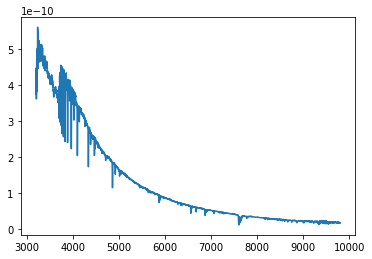

In [353]:
U = [3200,4000]
B = [4000,5000]
V = [5000,7000]
R = [5500,8000]
I = [7000,9000]
######### USER INPUTS ########
savefig  = False
filename = 'HD164353_V3.2'
data_directory = "./stelib_V3.2_corr_fits/"
form = '.fits'
flux_error_data = False
arr = [3.73, 22150, -0.16, 17.2]
##############################
F = {"V":0, "B":0}
effective_wave = {'B':4400, 'V':5500}
m = {'B':0, 'V':0}
B_ref = 4.26*(10**(-20))*(u.erg/(u.s*(u.cm**2)))*const.c.to(u.AA/u.s)*u.s*(1/(effective_wave['B']*u.AA)**2)
V_ref = 3.64*(10**(-20))*(u.erg/(u.s*(u.cm**2)))*const.c.to(u.AA/u.s)*u.s*(1/(effective_wave['V']*u.AA)**2)

log_g = np.array([np.floor(arr[0]*10)/10.0,np.ceil(arr[0]*10)/10.0])
teff = np.array([np.floor(arr[1]/100.0)*100.0,np.ceil(arr[1]/100.0)*100.0])
met = np.array([np.floor(arr[2]*10)/10.0,np.ceil(arr[2]*10)/10.0])
#Rad = np.arange(arr[3]-5,arr[3]+5,1)
#Rad = np.arange(arr[3]-0.2,arr[3]+0.2,0.1)
Rad = np.arange(arr[3]-0.5,arr[3]+0.5,0.1)
#Rad = np.append(np.arange(48,50,0.1), np.arange(53.5,55,0.1))
wavelength_range = [1000,100000]
s_wave = []
s_flux = []
s_wave, s_flux = pyasl.read1dFitsSpec(data_directory+filename+form)
hdulist = fits.open(data_directory + filename + form)
hdu = hdulist[0]
flux_unit = hdu.header["BUNIT"]
wave_unit = hdu.header["WAT1_001"].split()[-2].split('=')[-1]

del_arr = np.where(s_flux<=0)
s_flux = np.delete(s_flux,del_arr,0)
s_wave = np.delete(s_wave,del_arr,0)

s_wave_copy = np.copy(s_wave)
s_flux_copy = np.copy(s_flux)

best_r = 0
best_log_g = 0
best_teff = 0
best_met = 0
p = 0; # in mas
dp = 0;
with open(data_directory+"parallax_values.txt",'r') as f:
    for line in f:
        _a,b,c = line.split()
        if(_a == filename[:-5]):
            p = float(b)
            dp = float(c)
#p = 109.54 # mas
#dp = 0.17

D = 1000/p * u.parsec
D = D.to(u.m)
dD = (1000/p**2)*dp * u.parsec
dD = dD.to(u.m)
plt.plot(s_wave,s_flux)

Best fit model parameters: 
Log(g) = 3.7 [0.05]
Teff = 22200.0 [50] 
[Fe/H] = log_10((Fe/H)star/(Fe/H)sun) = -0.2 [0.05] 
R = 17.3 [4.86] R_sun 
Md = 4.7512351832320145e-19 
Chi-square value = 6.94924284854408e-10 
p value = 1.0
Percentage Mean Residual Value = 3.654720290722712 %


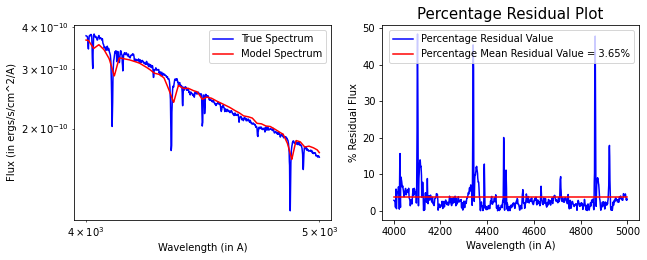

In [354]:
idx = np.where(np.logical_and(s_wave>=B[0], s_wave<=B[1]))
s_wave = s_wave[idx]
s_flux = s_flux[idx]

interpolated_flux, m_wave, m_flux, s_flux, s_wave, best_teff, best_log_g, best_met, best_r, Md, chi, p = return_flux(teff, log_g, met, Rad, s_wave, s_flux) 
interpolated_flux, m_wave, m_flux, s_flux, s_wave, best_teff, best_log_g, best_met, best_r, Md, chi, p = return_flux(np.array([best_teff]), np.array([best_log_g]), np.array([best_met]), np.array([best_r]),s_wave, s_flux )

print("Best fit model parameters: \nLog(g) = {} [{}]\nTeff = {} [{}] \n[Fe/H] = log_10((Fe/H)star/(Fe/H)sun) = {} [{}] \nR = {} [{:0.2f}] R_sun \nMd = {} \nChi-square value = {} \np value = {}".format(best_log_g,0.05,best_teff,50,best_met,0.05,np.round(best_r,2),np.amax([0.05,np.abs(np.sqrt(Md)*(dD/const.R_sun))]),Md,chi,p))
print("Percentage Mean Residual Value = {} %".format(np.mean((np.abs(interpolated_flux-s_flux)/s_flux)*100)))

t_f = 15
n_row = 1
n_col = 2
fig = plt.figure(figsize=(4 * n_col, 3 * n_row))
plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.20)

ax = fig.add_subplot(n_row,n_col,1)
#plt.loglog(a_uv.T[0],a_uv.T[1],'r')
plt.loglog(s_wave,s_flux,'b')
plt.loglog(m_wave,m_flux*Md,'r')
#plt.loglog(s_wave,s_flux+s_flux_e,'--b')
#plt.loglog(s_wave,s_flux-s_flux_e,'--b')
plt.xlabel("Wavelength (in A)")
plt.ylabel("Flux (in ergs/s/cm^2/A)")
plt.legend(["True Spectrum","Model Spectrum"])

ax = fig.add_subplot(n_row,n_col,2)
plt.plot(m_wave,(np.abs(interpolated_flux-s_flux)/s_flux)*100,'b')
plt.plot(m_wave, np.ones(m_wave.size)*np.mean((np.abs(interpolated_flux-s_flux)/s_flux)*100),'r')
plt.xlabel("Wavelength (in A)")
plt.ylabel("% Residual Flux")
plt.title("Percentage Residual Plot",fontsize=t_f)
plt.legend(["Percentage Residual Value","Percentage Mean Residual Value = {:0.2f}%".format(np.mean((np.abs(interpolated_flux-s_flux)/s_flux)*100))])
#plt.savefig(data_directory+"new_selected/"+filename+".png")

F["B"] = get_photometric_flux_band(m_wave,interpolated_flux,"B")
m['B'] = -2.5*np.log10(F['B']/B_ref.value)

Best fit model parameters: 
Log(g) = 3.7 [0.05]
Teff = 22100.0 [50] 
[Fe/H] = log_10((Fe/H)star/(Fe/H)sun) = -0.2 [0.05] 
R = 17.0 [4.77] R_sun 
Md = 4.587881212048688e-19 
Chi-square value = 1.1771994676353324e-10 
p value = 1.0
Percentage Mean Residual Value = 1.6218753697999126 %


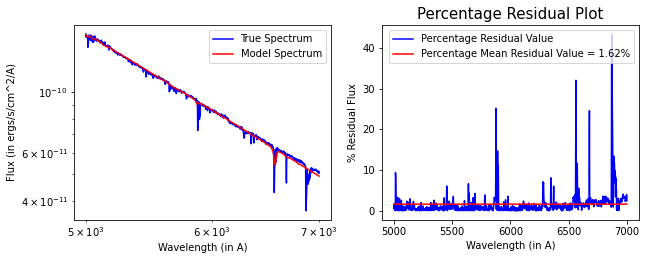

In [355]:
idx = np.where(np.logical_and(s_wave_copy>=V[0], s_wave_copy<=V[1]))
s_wave = s_wave_copy[idx]
s_flux = s_flux_copy[idx]

interpolated_flux, m_wave, m_flux, s_flux, s_wave, best_teff, best_log_g, best_met, best_r, Md, chi, p = return_flux(teff, log_g, met, Rad, s_wave, s_flux) 
interpolated_flux, m_wave, m_flux, s_flux, s_wave, best_teff, best_log_g, best_met, best_r, Md, chi, p = return_flux(np.array([best_teff]), np.array([best_log_g]), np.array([best_met]), np.array([best_r]),s_wave, s_flux )

print("Best fit model parameters: \nLog(g) = {} [{}]\nTeff = {} [{}] \n[Fe/H] = log_10((Fe/H)star/(Fe/H)sun) = {} [{}] \nR = {} [{:0.2f}] R_sun \nMd = {} \nChi-square value = {} \np value = {}".format(best_log_g,0.05,best_teff,50,best_met,0.05,np.round(best_r,2),np.amax([0.05,np.abs(np.sqrt(Md)*(dD/const.R_sun))]),Md,chi,p))
print("Percentage Mean Residual Value = {} %".format(np.mean((np.abs(interpolated_flux-s_flux)/s_flux)*100)))

t_f = 15
n_row = 1
n_col = 2
fig = plt.figure(figsize=(4 * n_col, 3 * n_row))
plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.20)

ax = fig.add_subplot(n_row,n_col,1)
#plt.loglog(a_uv.T[0],a_uv.T[1],'r')
plt.loglog(s_wave,s_flux,'b')
plt.loglog(m_wave,m_flux*Md,'r')
#plt.loglog(s_wave,s_flux+s_flux_e,'--b')
#plt.loglog(s_wave,s_flux-s_flux_e,'--b')
plt.xlabel("Wavelength (in A)")
plt.ylabel("Flux (in ergs/s/cm^2/A)")
plt.legend(["True Spectrum","Model Spectrum"])

ax = fig.add_subplot(n_row,n_col,2)
plt.plot(m_wave,(np.abs(interpolated_flux-s_flux)/s_flux)*100,'b')
plt.plot(m_wave, np.ones(m_wave.size)*np.mean((np.abs(interpolated_flux-s_flux)/s_flux)*100),'r')
plt.xlabel("Wavelength (in A)")
plt.ylabel("% Residual Flux")
plt.title("Percentage Residual Plot",fontsize=t_f)
plt.legend(["Percentage Residual Value","Percentage Mean Residual Value = {:0.2f}%".format(np.mean((np.abs(interpolated_flux-s_flux)/s_flux)*100))])
#plt.savefig(data_directory+"new_selected/"+filename+".png")

F["V"] = get_photometric_flux_band(m_wave,interpolated_flux,"V")
m['V'] = -2.5*np.log10(F['V']/V_ref.value)

In [356]:
w = csv.writer(open(data_directory+"new_selected/BV_only/"+filename+"_apparent_magnitude.csv", "w"))
for key, val in m.items():
    w.writerow([key, val])

In [358]:
w = csv.writer(open(data_directory+"new_selected/BV_only/"+filename+"_photometric_flux.csv", "w"))
for key, val in F.items():
    w.writerow([key, val])

In [359]:
for k, v in m.items():
    v = LessPrecise(round(v, 2))
    print (k,v)

print(r"Mv {}^{}_{}".format(np.round(get_dist_modulus(m["V"],D.to(u.parsec)),2),np.round(get_dist_modulus(m["V"],(D+dD).to(u.parsec)),3)-np.round(get_dist_modulus(m["V"],D.to(u.parsec)),2),np.round(get_dist_modulus(m["V"],(D-dD).to(u.parsec)),2)-np.round(get_dist_modulus(m["V"],D.to(u.parsec)),3)))

B 3.45
V 3.7
Mv -5.06^-0.5370000000000008_0.7190000000000003
